## Imports and Setup

In [5]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import load_results
from ema_workbench.analysis import pairs_plotting, prim

In [6]:
results = load_results('./output/base_case_results__100000_scenarios.tar.gz')

In [7]:
experiments, outcomes = results
experiments.shape

(100000, 53)

----------------------------------------

## Pre-filtering Scenarios by Outcome

In [8]:
## FILTER OUT CASES W NO DAMAGE TO A.4
experiments_to_drop = []
for i, result in enumerate(outcomes['A4_Expected_Annual_Damage']):
    if result == 0:
        experiments_to_drop.append(i)

experiments = experiments.drop(experiments_to_drop)
new_outcomes = {}
for key in outcomes:
    drop_index = 0
    new_outcomes[key] = np.array([])
    for i in range(len(outcomes[key])):
        if drop_index == len(experiments_to_drop):
            break
        elif i == experiments_to_drop[drop_index]:
            drop_index += 1
        else:
            new_outcomes[key] = np.append(new_outcomes[key], outcomes[key][i])
outcomes = new_outcomes

print(len(outcomes['A4_Expected_Annual_Damage']))
results = (experiments, outcomes)

39633


---------------------------------------

## Visual Analysis

First, we can look at a pair-plotted scatter plot to visualize how our outcomes are related to each other and how differences in policy influence differences in outcomes. This is especially helpful if we are running analysis using hand-crafted policies or those decided on by the Directed Search proces.

In [9]:
outcomes_of_interest = ['A4_Expected_Annual_Damage', 'A4_Expected_Number_of_Deaths',
                        'Total_Expected_Annual_Damage', 'Total_Expected_Number_of_Deaths',]

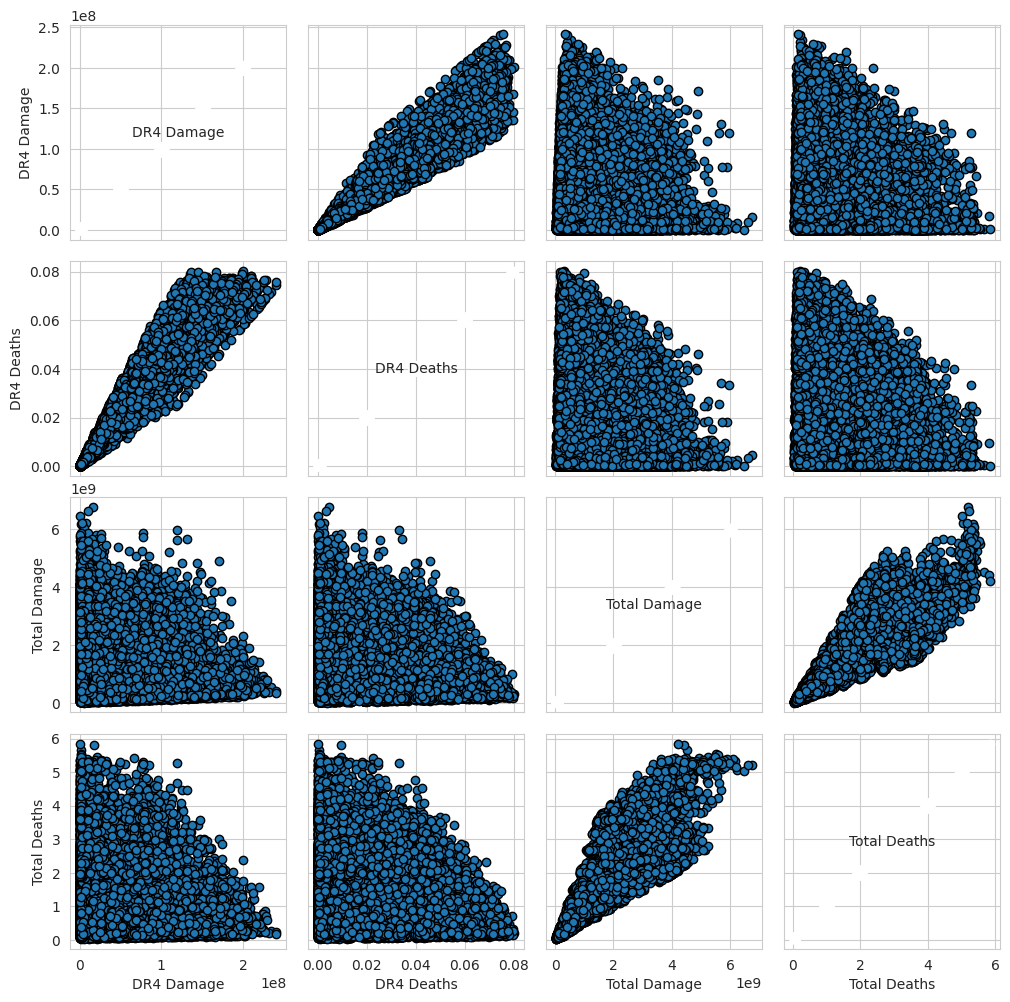

In [10]:
outcomes_subset = {k:outcomes[k] for k in outcomes_of_interest if k in outcomes}

ylabels = {
    'A4_Expected_Annual_Damage'        : 'DR4 Damage',
    'A4_Expected_Number_of_Deaths'     : 'DR4 Deaths',
    'Total_Expected_Annual_Damage'      : 'Total Damage',
    'Total_Expected_Number_of_Deaths'   : 'Total Deaths'
}
fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes_subset,
                                         legend=True, ylabels=ylabels,
                                         linewidth=0,
                                        )
fig.set_size_inches(12, 12)
plt.savefig('img/scenario_discovery__outcomes_pairplot.png')
plt.show()

In [11]:
ooi = 'A4_Expected_Annual_Damage'

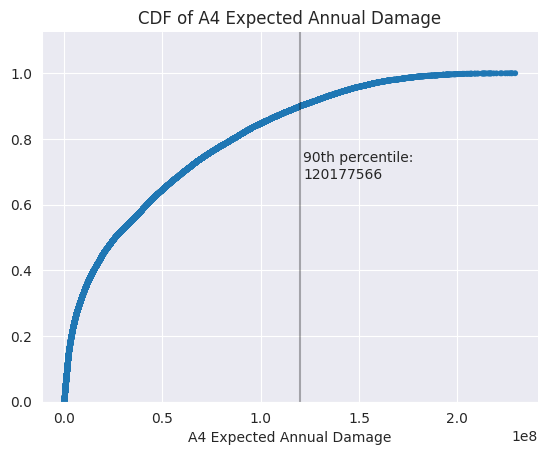

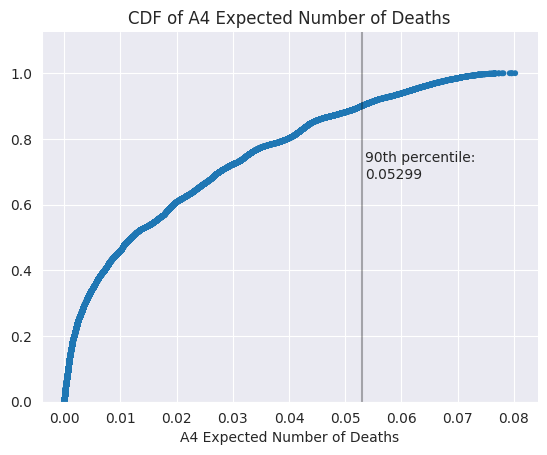

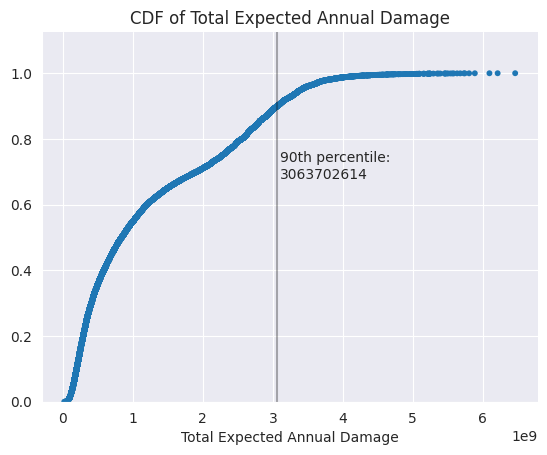

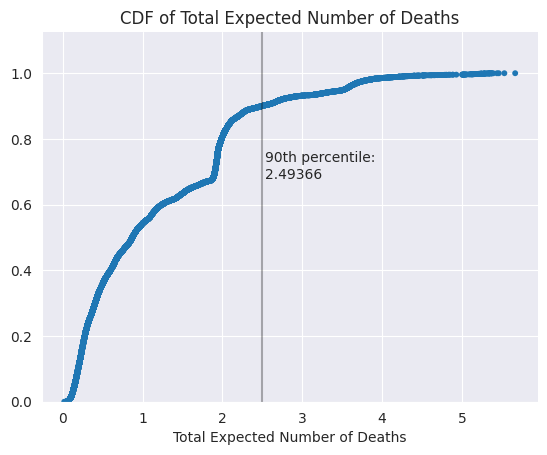

In [12]:
N = experiments.shape[0]
performance_threshold = None
# for outcome in outcomes_of_interest:
for col in outcomes_of_interest:
    # Build data for plotting
    df = pd.DataFrame()
    df[col] = outcomes[col]
    df['policy'] = experiments['policy']
    df = df.sort_values(by=col, ascending=True)
    df['y'] = np.arange(N)/N
    df = df.reset_index()
    
    # Plot
    sns.set_style('darkgrid')

    ax = sns.scatterplot(data=df, x=col, y='y', hue='policy',
                         legend=False, size=1, linewidth=0,
                         palette='tab10')

    # Note percentile locations for plotting
    ninety = int(N*0.9)
    annotation_point = int(N*0.68)/N # tested to line up with a gridline

    # Plot and label a line at the 90th percentile
    ax.axvline(df[col][ninety], label=str(df[col][ninety]),
               color='k', alpha=0.3)
    if col.split('_')[-1] == 'Deaths':
        ax.annotate(text=f"90th percentile:\n{df[col][ninety]:.5f}", 
                    xy=(df[col][ninety], annotation_point),
                    xytext=(3, 0), textcoords='offset pixels')
    else:
        ax.annotate(text=f"90th percentile:\n{df[col][ninety]:.0f}", 
                    xy=(df[col][ninety], annotation_point),
                    xytext=(3, 0), textcoords='offset pixels')
    
    # Save performance threshold (90th percentile of outcome of interest)
    if (col == ooi):
        performance_threshold = df[col][ninety]

    # Set up graph
    col_name = ' '.join(col.split('_'))

    sns.despine(ax=ax)
    ax.set(xlabel=col_name, ylabel=None, ylim=[0, 1.125])

    plt.title(f'CDF of {col_name}')

    plt.savefig(f'img/scenario_discovery__CDF_{col}.png')
    plt.show()

-----------------------------------

## Scenario Discovery

put words here to describe what we're doing and why

In [13]:
uncertainties = ['A0_ID_flood_wave_shape', 'A1_Bmax', 'A1_Brate', 'A1_pfail', 'A2_Bmax',
                 'A2_Brate', 'A2_pfail', 'A3_Bmax', 'A3_Brate', 'A3_pfail', 'A4_Bmax',
                 'A4_Brate', 'A4_pfail', 'A5_Bmax', 'A5_Brate', 'A5_pfail',
                 'discount_rate_0', 'discount_rate_1', 'discount_rate_2',]

In [14]:
prim_alg = prim.setup_prim(results,
                           classify=lambda y: y[ooi] > performance_threshold,
                           threshold=0.75,
                           incl_unc=uncertainties,
                           mass_min=0.01
                           )
box1 = prim_alg.find_box()

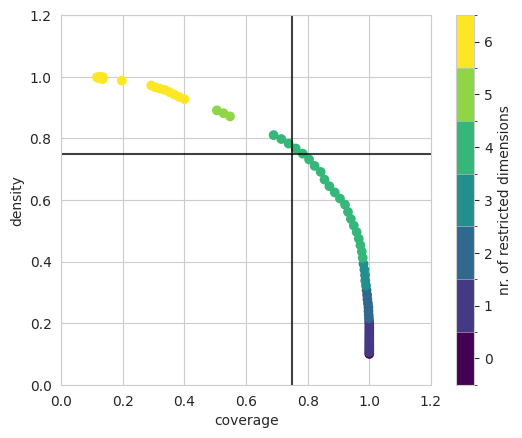

In [15]:
sns.set_style('whitegrid')

box1.show_tradeoff()

plt.hlines(y=[0.75], xmin=0, xmax=1.2, colors='k', alpha=0.75)
plt.vlines(x=[0.75], ymin=0, ymax=1.2, colors='k', alpha=0.75)
plt.savefig('img/scenario_discovery__prim_trajectory')
plt.show()

In [49]:
candidates = box1.peeling_trajectory
candidates = candidates[(candidates.coverage > 0.75)
                         & (candidates.density > 0.75)]
candidates

,coverage,density,id,mass,mean,res_dim
44,0.784002,0.750302,44,0.104484,0.750302,4
45,0.761292,0.767099,45,0.099235,0.767099,4


In [67]:
best_box = candidates[candidates.density
                      == candidates.density.max()]
best_box_idx = int(best_box.index[0])

box1.select(best_box_idx)
best_box_idx

45

coverage     0.761292
density      0.767099
id          45.000000
mass         0.099235
mean         0.767099
res_dim      4.000000
Name: 45, dtype: float64

            box 45                                  
               min       max       qp value qp value
A4_pfail  0.000006  0.093803            NaN      0.0
A1_pfail  0.369174  0.999989  7.565026e-235      NaN
A3_pfail  0.247092  0.999985   3.976542e-80      NaN
A2_pfail  0.123342  0.999982   1.250991e-22      NaN



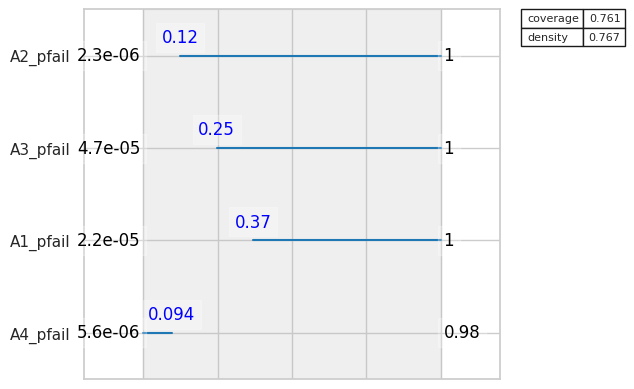

In [124]:
box1.inspect()

sns.set_style('whitegrid')

box1.inspect(style="graph", ticklabel_formatter='{}', boxlim_formatter='{:.2g}')
plt.savefig('img/scenario_discovery_prim_boundary.png')
plt.show()

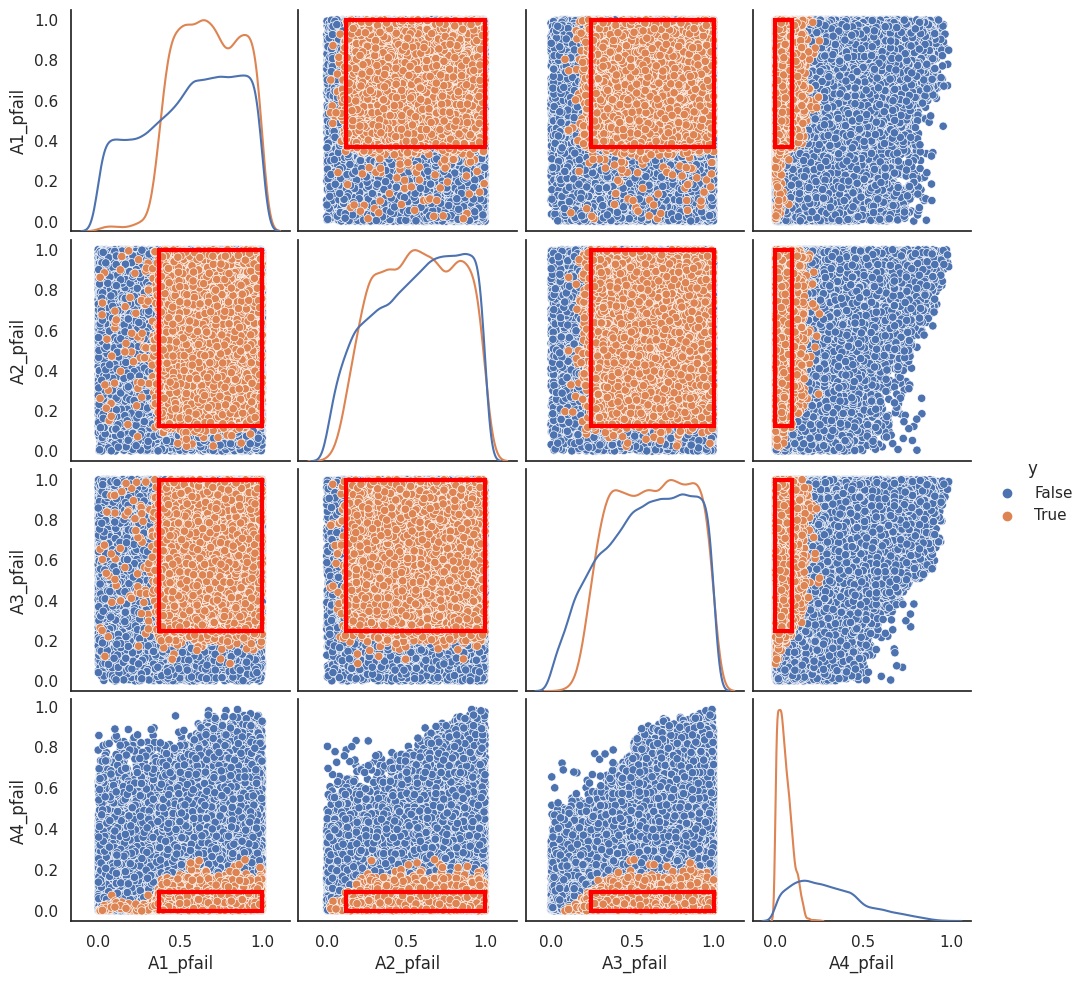

In [125]:
sns.set_style('white')
box1.show_pairs_scatter()
plt.savefig('img/scenario_discovery_prim_pairs_scatter.png')
plt.show()

In [ ]:
limits = box1.box_lims[best_box_idx]
limits

,A0_ID_flood_wave_shape,A1_Bmax,A1_Brate,A1_pfail,A2_Bmax,A2_Brate,A2_pfail,A3_Bmax,A3_Brate,A3_pfail,A4_Bmax,A4_Brate,A4_pfail,A5_Bmax,A5_Brate,A5_pfail,discount_rate_0,discount_rate_1,discount_rate_2
0,0,30.018626,"{1.5, 10.0, 1.0}",0.369174,30.018827,"{1.5, 10.0, 1.0}",0.123342,30.002562,"{1.0, 10.0, 1.5}",0.247092,30.022694,"{1.0, 10.0, 1.5}",0.000006,30.016911,"{1.5, 10.0, 1.0}",0.000010,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
1,132,349.991644,"{1.5, 10.0, 1.0}",0.999989,349.990873,"{1.5, 10.0, 1.0}",0.999982,349.996053,"{1.0, 10.0, 1.5}",0.999985,349.999154,"{1.0, 10.0, 1.5}",0.093803,349.980059,"{1.5, 10.0, 1.0}",0.999974,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"


--------------------------

## Filter, Sort, and Save Outputs

In [ ]:
combined_df = experiments.copy()
for key in outcomes:
    combined_df[key] = outcomes[key]
combined_df['Within Limit'] = True
combined_df.head()

,A0_ID_flood_wave_shape,A1_Bmax,A1_Brate,A1_pfail,A2_Bmax,A2_Brate,A2_pfail,A3_Bmax,A3_Brate,A3_pfail,...,A3_Expected_Annual_Damage,A3_Expected_Number_of_Deaths,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,A5_Expected_Annual_Damage,A5_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths,Within Limit
0,63,101.259903,1.5,0.408709,111.632141,1.5,0.135391,73.153987,1.0,0.451986,...,2.728748e+07,0.041352,8.757227e+06,0.003369,0.000000e+00,0.000000,0.0,1.723623e+09,1.132815,True
5,43,61.921647,1.5,0.047811,56.262052,1.5,0.017475,311.766050,1.5,0.162441,...,4.588641e+08,0.618858,1.089178e+06,0.000370,0.000000e+00,0.000000,0.0,5.245450e+09,3.320664,True
6,68,46.765651,10.0,0.822219,219.181706,1.0,0.807496,282.354956,1.5,0.910047,...,2.832855e+07,0.061809,5.042158e+05,0.000339,4.436058e+08,0.472837,0.0,4.992548e+08,0.564465,True
7,109,59.067851,10.0,0.145279,337.123645,1.5,0.279685,318.667608,10.0,0.304903,...,3.231852e+08,0.525432,2.398455e+07,0.010036,8.355113e+06,0.006937,0.0,3.551046e+09,2.535472,True
9,129,139.473910,10.0,0.260311,203.502199,1.5,0.428188,245.749023,10.0,0.669542,...,0.000000e+00,0.000000,5.565392e+06,0.002156,0.000000e+00,0.000000,0.0,3.351856e+09,1.876356,True


In [ ]:
print(combined_df.shape)

(39633, 67)


In [ ]:
# Apply PRIM constraint
for idx, row in combined_df.iterrows():
    for unc in limits:
        if (type(limits.loc[0, unc]) == set):
            if row[unc] not in limits.loc[0, unc]:
                combined_df.at[idx, 'Within Limit'] = False
        else:
            if row[unc] < limits.loc[0, unc] or row[unc] > limits.loc[1, unc]:
                combined_df.at[idx, 'Within Limit'] = False

In [ ]:
combined_df = combined_df[combined_df['Within Limit']]
combined_df = combined_df.drop(['Within Limit'], axis=1)
combined_df.shape

(3933, 66)

In [ ]:
combined_df = combined_df.sort_values(by=ooi, ascending=False)
combined_df.head()

,A0_ID_flood_wave_shape,A1_Bmax,A1_Brate,A1_pfail,A2_Bmax,A2_Brate,A2_pfail,A3_Bmax,A3_Brate,A3_pfail,...,A2_Expected_Number_of_Deaths,A3_Expected_Annual_Damage,A3_Expected_Number_of_Deaths,A4_Expected_Annual_Damage,A4_Expected_Number_of_Deaths,A5_Expected_Annual_Damage,A5_Expected_Number_of_Deaths,Total_Infrastructure_Costs,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
71789,98,245.492589,1.5,0.730879,103.700541,1.5,0.811144,212.666805,1.5,0.966618,...,0.023369,2.304640e+07,0.031816,2.412142e+08,0.075778,0.0,0.0,0.0,3.414177e+08,0.155714
71139,23,262.554875,10.0,0.969102,280.377067,10.0,0.526979,187.570341,1.0,0.696104,...,0.094929,3.469710e+07,0.046798,2.409890e+08,0.074537,0.0,0.0,0.0,4.098237e+08,0.216264
11550,60,275.708351,1.0,0.572317,265.693511,1.5,0.420025,121.947334,10.0,0.759597,...,0.093453,0.000000e+00,0.000000,2.344626e+08,0.071654,0.0,0.0,0.0,5.497785e+08,0.262440
23082,40,62.466739,1.5,0.880597,136.376759,1.5,0.461343,142.623248,10.0,0.675062,...,0.094292,3.229027e+07,0.043697,2.319523e+08,0.070747,0.0,0.0,0.0,3.979242e+08,0.208735
98457,27,262.062862,10.0,0.563094,193.450856,10.0,0.674911,273.473465,1.5,0.496738,...,0.037259,2.576351e+08,0.345692,2.294862e+08,0.072420,0.0,0.0,0.0,7.903236e+08,0.588542


In [ ]:
combined_df.to_csv('output/base_case_results__100000_scenarios__prim_filtered.csv', index=True)